Cat and Dog Classification
=============

In [14]:
import os
import re
import numpy as np
import zipfile
from numpy import genfromtxt
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
import tensorflow as tf

### Instruction
Please download the dataset from [https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) and put on `src/data` folder

In [39]:
CAT = 0
DOG = 1



Cache ./data/train.zip.cache
['cat.0.jpg' 'cat.1.jpg' 'cat.10.jpg' 'cat.100.jpg' 'cat.1000.jpg'
 'cat.10000.jpg' 'cat.10001.jpg' 'cat.10002.jpg' 'cat.10003.jpg'
 'cat.10004.jpg']
./data/train
Cache ./data/test.zip.cache


In [3]:
train_dataset = []
train_labels = []
validate_dataset = []
validate_labels = []
test_dataset = []
complete_load_data = False

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

if train_csv is not None and test_csv is not None:
  with open(train_csv, 'rb') as f:
    data = pickle.load(f)
    dataset = data[1:,1:]
    labels = data[1:,0]
    dataset, labels = randomize(dataset, labels)
    
    # train_size = (int) (dataset.shape[0] * 0.7)
    validate_size = 5000
    
    train_dataset = dataset[0:-validate_size]
    train_labels = labels[0:-validate_size]
    
    validate_dataset = dataset[-validate_size:]
    validate_labels = labels[-validate_size:]
    
  with open(test_csv, 'rb') as f:
    data = pickle.load(f)
    test_dataset = data[1:]
  complete_load_data = True
  print('Load data complete')
else:
  print('Something wrong with loading file. Please try again.')

Load data complete


Preview the data to make sure that dataset is correct.

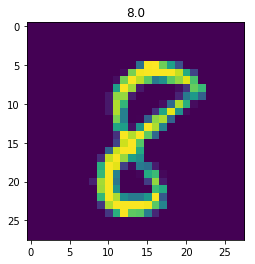

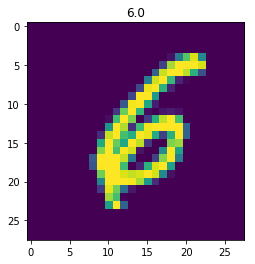

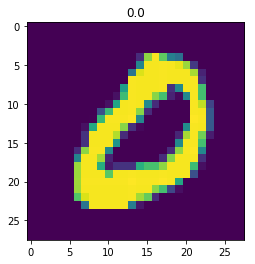

In [4]:
def preview_number(data, label=None):
  number = data.reshape(28, 28)
  plt.figure()
  plt.imshow(number)
  if label is not None:
    plt.title(label)
  
for i in xrange(0,3):
  preview_number(train_dataset[i], train_labels[i])

### Data Prepossessing
Convert labels to one-hot-encoder format

In [5]:
num_labels = 10

In [6]:
def one_hot_encoder(labels):
  labels.astype(int)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return labels

train_labels = one_hot_encoder(train_labels)
validate_labels = one_hot_encoder(validate_labels)

Normalization

In [7]:
def normalization(data):
  return data / 255

train_dataset = normalization(train_dataset)
validate_dataset = normalization(validate_dataset)
test_dataset = normalization(test_dataset)

Reshape

In [8]:
def reshape_input(data):
  return data.reshape((-1, 28, 28, 1))

train_dataset = reshape_input(train_dataset)
validate_dataset = reshape_input(validate_dataset)
test_dataset = reshape_input(test_dataset)

In [9]:
# Debug shape of data to make sure data is correct format

print(train_dataset.shape)
print(train_labels.shape)

print(validate_dataset.shape)
print(validate_labels.shape)

print(test_dataset.shape)

(37000, 28, 28, 1)
(37000, 10)
(5000, 28, 28, 1)
(5000, 10)
(28000, 28, 28, 1)


## Processing (with CNN method)

TensorFlow graph initialization

In [10]:
# Constant

patch_size = 5
batch_size = 32
input_size = 200

In [11]:
graph = tf.Graph()

with graph.as_default():
  
  # Input
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, 28, 28, 1))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_input_data = tf.placeholder(tf.float32, shape=(input_size, 28, 28, 1))
  keep_prob = tf.placeholder(tf.float32)
  
  # Variable
  def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
  
  def bias_variable(shape):
    return tf.Variable(tf.constant(0.1), shape)
  
  W1 = weight_variable([patch_size, patch_size, 1, 32])
  B1 = bias_variable([32])
  
  W2 = weight_variable([patch_size, patch_size, 32, 64])
  B2 = bias_variable([64])
  
  W3 = weight_variable([7 * 7 * 64, 256])
  B3 = bias_variable([256])
  
  W4 = weight_variable([256, num_labels])
  B4 = bias_variable([num_labels])
  
  # Model
  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
  
  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  
  def model(x):  
    h_conv1 = tf.nn.relu(conv2d(x, W1) + B1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W2) + B2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W3) + B3)
    
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    return tf.matmul(h_fc1_drop, W4) + B4
  
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
      labels = tf_train_labels,
      logits = logits
    )
  )
  
  # Optimizer
  optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
  
  # Predictions
  train_prediction = tf.nn.softmax(logits)
  prediction_fn = tf.nn.softmax(model(tf_input_data))

In [12]:
num_steps = 2001

def predict_result(predictions):
  return np.argmax(predictions, 1)

def accuracy(predictions, labels):
  return (100.0 * np.sum(predict_result(predictions) == predict_result(labels))
          / predictions.shape[0])

def predict_all(input_data):
  predict_data = np.array([])
  
  offset = 0
  size = input_data.shape[0]
  while offset + input_size <= size:
    predictions = session.run(
      [prediction_fn],
      feed_dict = { 
        tf_input_data: input_data[offset : (offset + input_size)],
        keep_prob: 1.0
      }
    )
    predict_data = np.append(predict_data, predictions[0])
    offset += input_size
    

  return predict_data.reshape((-1, num_labels))
  

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  
  for step in xrange(num_steps):
    offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
    batch_data = train_dataset[offset : (offset + batch_size)]
    batch_labels = train_labels[offset : (offset + batch_size)]
    
    feed_dict = {
      tf_train_dataset: batch_data,
      tf_train_labels: batch_labels,
      keep_prob: 0.5
    }
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction],
      feed_dict = feed_dict
    )
    
    if (step % 50 == 0):
      print('Step %d: %f' % (step, l))
      print('Batch accuracy: %.2f%%' % accuracy(predictions, batch_labels))
      
    if (step % 200 == 0):
      validate_prediction = predict_all(validate_dataset)

      print('\n==> Validation accuracy: %.2f%% \n' % accuracy(
        validate_prediction, 
        validate_labels[0 : validate_prediction.shape[0]]
      ))
      
  print('\nPredict test data')
  
  result = np.arange(1, test_dataset.shape[0] + 1).reshape((-1,1))
  
  test_prediction = predict_result(predict_all(test_dataset)).reshape((-1,1))
  result = np.append(result, test_prediction, axis=1).astype(int)
  
  np.savetxt(
    os.path.join(root_path, 'data/prediction.txt'), 
    result, 
    delimiter=",",
    header="ImageId,Label",
    fmt='%d',
    comments=''
  )

  print('Finish!!!....')

Initialized
Step 0: 5.067106
Batch accuracy: 18.75%

==> Validation accuracy: 13.74% 

Step 50: 1.016535
Batch accuracy: 65.62%
Step 100: 0.391606
Batch accuracy: 93.75%
Step 150: 0.515392
Batch accuracy: 84.38%
Step 200: 0.141733
Batch accuracy: 96.88%

==> Validation accuracy: 93.60% 

Step 250: 0.407947
Batch accuracy: 84.38%
Step 300: 0.074093
Batch accuracy: 96.88%
Step 350: 0.079867
Batch accuracy: 96.88%
Step 400: 0.215813
Batch accuracy: 93.75%

==> Validation accuracy: 96.12% 

Step 450: 0.359075
Batch accuracy: 90.62%
Step 500: 0.189021
Batch accuracy: 87.50%
Step 550: 0.453445
Batch accuracy: 90.62%
Step 600: 0.232590
Batch accuracy: 93.75%

==> Validation accuracy: 97.18% 

Step 650: 0.109027
Batch accuracy: 96.88%
Step 700: 0.365131
Batch accuracy: 96.88%
Step 750: 0.106202
Batch accuracy: 96.88%
Step 800: 0.190845
Batch accuracy: 87.50%

==> Validation accuracy: 97.76% 

Step 850: 0.147894
Batch accuracy: 93.75%
Step 900: 0.023756
Batch accuracy: 100.00%
Step 950: 0.01206